# Отток клиентов

## Подготовка данных

### Обзор данных

!pip install scikit-learn==1.1.3

from sklearn.preprocessing import OneHotEncoder

In [7]:
import warnings

import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    mean_absolute_error,
    precision_score,
    recall_score
) 
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)  

In [8]:
# настройки
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

# константы заглавными буквами
RANDOM_STATE = 123456

In [9]:
# Функция для более полного вывода информации одной строкой
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [10]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    display('Файл не найден!')

In [11]:
get_data_info(data)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1351,1352,15635435,White,648,France,Female,54,9.0,120633.42,1,0,0,5924.38,1
5024,5025,15720583,Finch,745,Germany,Female,44,0.0,119638.21,1,1,1,34265.08,1
9093,9094,15671334,Nixon,527,France,Male,31,4.0,0.00,1,1,0,169361.89,0
9725,9726,15712536,Fallaci,625,France,Female,36,3.0,0.00,2,1,0,41295.10,1
1423,1424,15589221,Kennedy,657,Germany,Male,30,1.0,139762.13,2,1,1,23317.88,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


In [12]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

### Оценка пропущенных значений

In [13]:
def nan_percent_plot(df):
    nan_percent = df.isna().mean()*100
    if nan_percent[nan_percent.values > 0].count() > 0:
        (
            nan_percent[nan_percent.values > 0]
            .sort_values(ascending=True)
            .plot(kind = 'barh', figsize=(16, 6), fontsize=22)
            .set_title('Процент пропущенных значений' + "\n", fontsize=22)
        );
        plt.ylabel('Признаки', fontsize=22);
        plt.xlabel('% (от всего датасета)', fontsize=22);
    else:
        print('Пропусков не найдено')

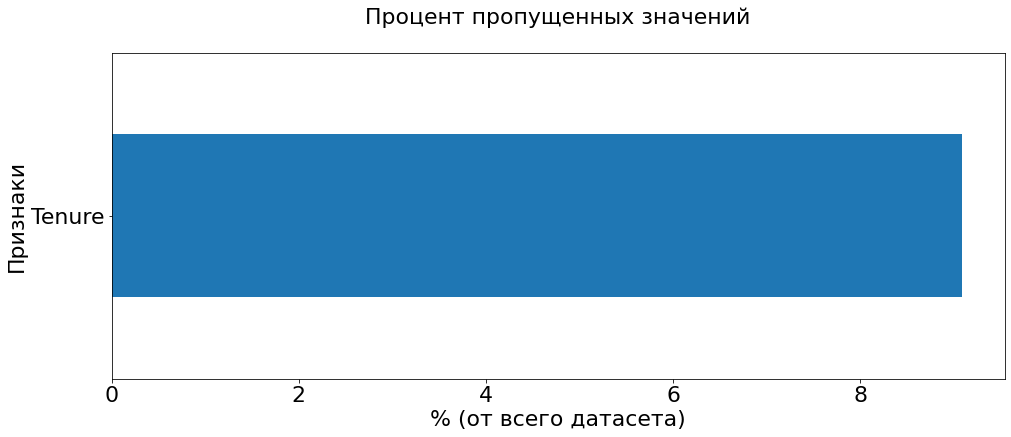

In [14]:
nan_percent_plot(data)

### Гистограммы числовых значений

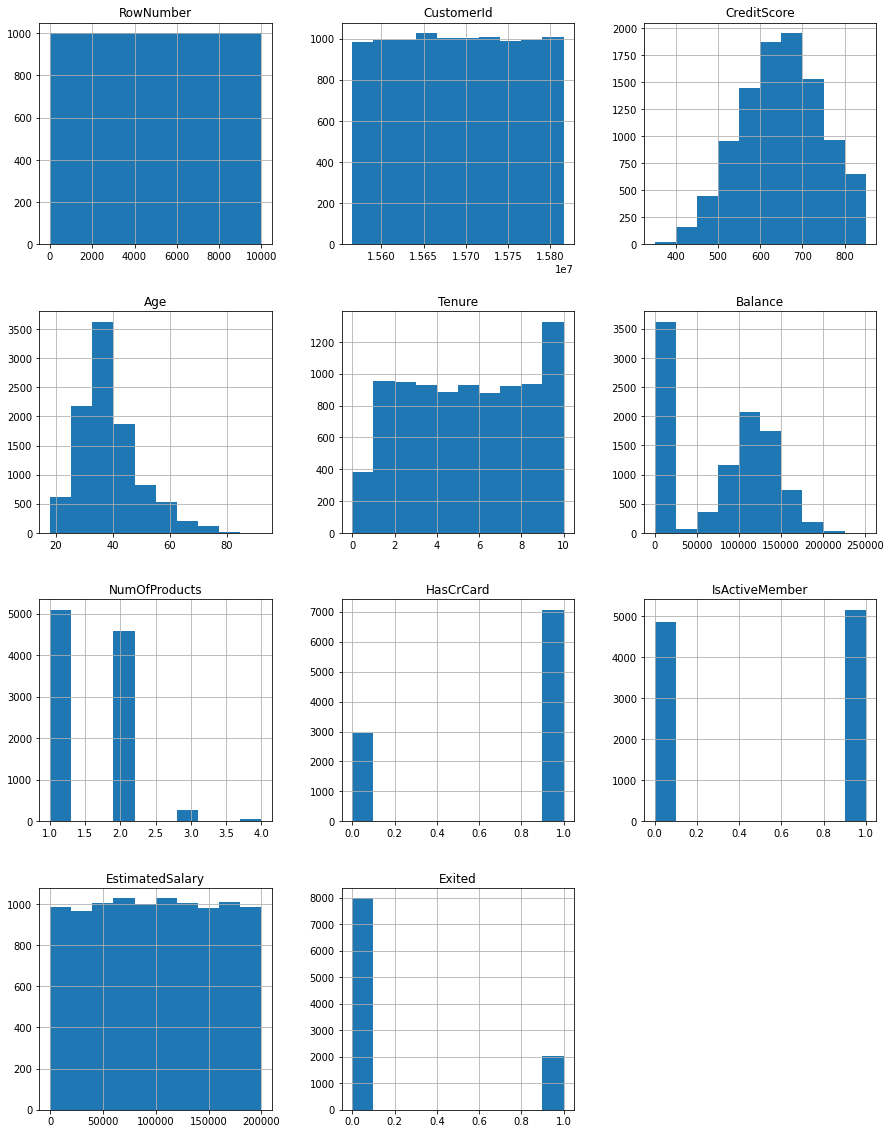

In [15]:
data.hist(figsize=(15, 20));

На графиках виден дисбаланс в признаках наличия кредитной карты и целевом признаке, большое количество клиентов с нулевыми или оконулевыми счетами

### Оценка выбросов

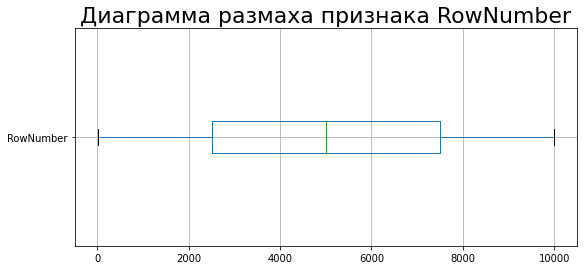

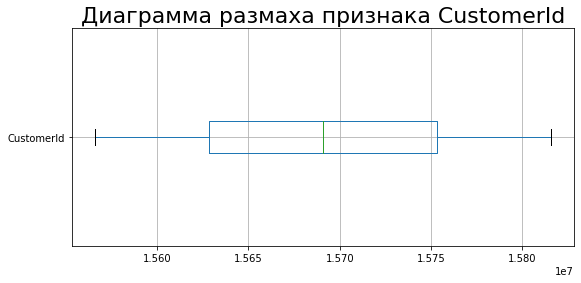

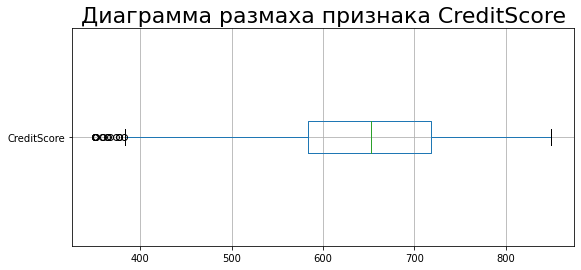

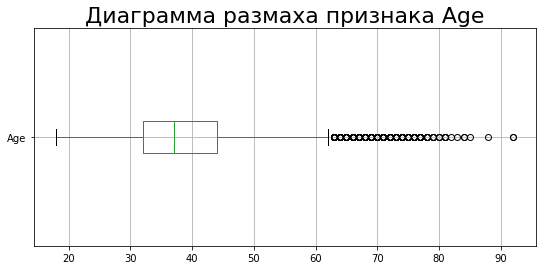

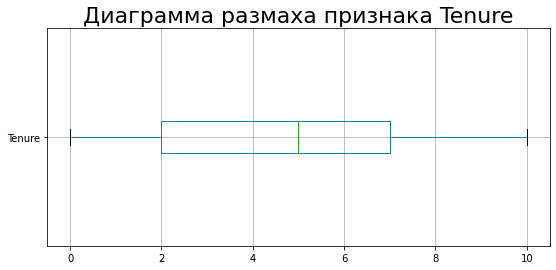

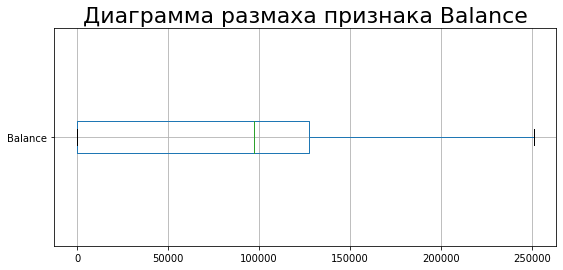

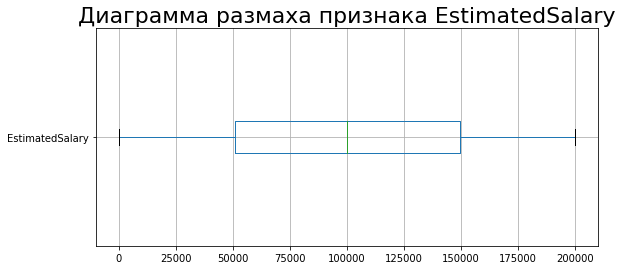

In [16]:
columns = list(data.select_dtypes(['int', 'float']).columns)

categorial_columns = ['Exited', 'IsActiveMember', 'NumOfProducts', 'HasCrCard']

for col in categorial_columns:
    columns.remove(col)

for col in columns:
    (
        data
        .boxplot(col, vert = False, figsize=(9, 4))
        .set_title(f'Диаграмма размаха признака {col}', fontsize=22)
    );
    plt.show();

Из-за разного масштаба признаков пришлось через цикл выводить боксплоты, каждый отдельно. Самое большое количество выбросов наблюдается в признаках `CreditScore` и `Age`, возможно, придется использовать стандартизацию (она менее чувствительна к выбросам)

### Удаление неиформативных признаков

Есть несколько не важных, по моему предположению, столбцов, например пол и фамилия. Фамилию я сразу удалил - очевидно не важный признак, также удалил столбец `RowNumber` который по сути дублирует индекс+1 и является лишней информацией для модели, также как и столбец с id клиента (`CustomerId`), эти данные важны для человека, а не для модели.

In [17]:
data = data.drop('Surname', axis=1)
data = data.drop('RowNumber', axis=1)
data = data.drop('CustomerId', axis=1)

#data_ohe = pd.get_dummies(data, columns=['Geography', 'Gender'], drop_first=True)

### Обработка пропусков

Так как я много что перепробовал, в том числе машинное обучение для заполнения пропусков (задача регрессии), пришел к тому, что данный признак не очень важен для моделей, но удалять записи не стоит так как в них могут содержаться важные данные. В итоге пути было три: обучение модели для заполнения пропусков (модель почему-то предложила заполнить все пропуски цифрой 5, но это без масштабирования, на коленке, с незначительным изменением стандартного отклонения), заполнение случайными значениями от 1 до 10 и также SimpleImputer.

Если признак не сильно важен, то randint, если признак достаточно важен, то SimpleImputer, если признак важен, то надо серьезно заняться вопросом обучения модели для заполнения пропусков.

Так как, в процессе выяснилось (комьюнити учеников), что данный признак не сильно важен, но важны другие признаки, то использовал randint от 1 до 10 для пропусков, это должно создать более-менее нормальное распределение (909 значений должно хватить)

In [18]:
np.std(data['Tenure'])

2.8945640222569913

Ознакомился с распределением данных

In [19]:
num_counts = data[~data['Tenure'].isna()]['Tenure'].value_counts()
num_counts

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

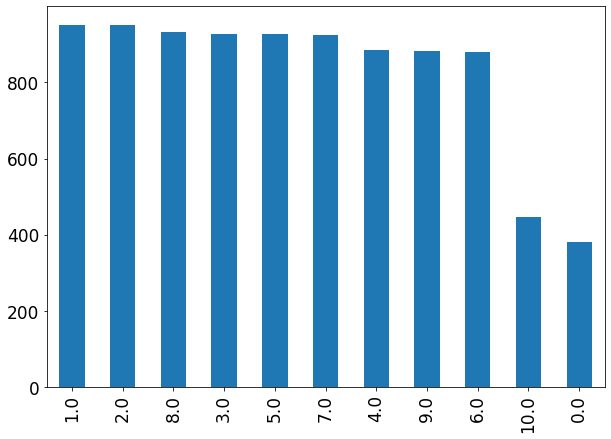

In [20]:
data[~data['Tenure'].isna()]['Tenure'].value_counts().plot(kind='bar', figsize=(10, 7), fontsize=17);

Для того чтобы наиболее верно заполнить пропуски, можно заполнить их исходя из текущего распределения данных, например, вероятность числа 10 в данном ряду - 4.9%. Неизвестно, какие именно данные были утеряны, может быть категориальные, но после ML-метода, способ заполнения пропусков случайным числом видится мне наиболее оптимальным, заполнив пропуски - не потеряем данные в других признаках

In [35]:
# Считаем вероятности появления чисел
proba = []
for num in range(0, 11):
    x = num_counts[num] / 9091
    proba.append(round(x, 3))

# Решил перенести объявление функции ниже, а то вдруг вероятности пустые останутся или еще что
def fiil_nan_rand(ser):
    return choices(np.arange(0.0, 11.0, 1.0), weights=proba)[0]

In [17]:
data.loc[data['Tenure'].isna(), 'Tenure'] = data.loc[data['Tenure'].isna(), 'Tenure'].apply(fiil_nan_rand)
data['Tenure'] = data['Tenure'].astype('int')

Перевел столбец в целочисленный формат, проверил стандартное отклонение, оно практически не изменилось (при каждом новом запуске ячеек, значение незначительно меняется, параметра, позволяющего зафиксировать псевдослучайность нету и, насколько я понимаю, не должно быть)

In [18]:
np.std(data['Tenure'])

2.900283391325751

Можно было бы загрузить отдельно данные где пропусков нет и вставить их в данный датасет или сохранить этот набор в файл, а потом выгрузить его. Но оно не стоит затраченного времени, расхождения значений стандартного отклонения с каждым новым запуском в пределах погрешности +- 0.005-7

### Кодирование признаков и разделение выборки

Так как подбор гиперпараметров будет осуществляться с помощью перекрестной проверки (кросс-валидации, в т.ч. линейных моделей) - разделил датасет на тренировочную и тестовую выборки с соотношением 3:1:1 (хотя на самом деле, я не знаю какой процент для валидации берет функция)

Также в дальнейшем мне понадобится валидационная выборка, для улучшения качества модели (например, посредством изменения порога вероятности класса, а для этого нужны вероятности предсказаний для валидационной выборки, чтобы подобрать оптимальный порог, а затем проверить на тесте), но пока разделил на две выборки из-за кросс-валидации, которая идет далее

In [65]:
def oneHotEncode(df):
    # инициализируем кодировщик
    ohe = OneHotEncoder()

    # получаем список незакодированных признаков
    non_encoded_columns = [col for col in df.columns if df[col].dtype == 'object']

    # кодируем незакодированные признаки
    encoded_columns = ohe.fit_transform(df[non_encoded_columns]).toarray()

    # сохраняем имена кодированных признаков
    encoded_columns_names = ohe.get_feature_names(non_encoded_columns)

    # сохраняем имена исходных незакодированных признаков
    non_encoded_columns_names = df[non_encoded_columns].columns.values

    # удаляем незакодированные признаки
    df.drop(non_encoded_columns, axis=1, inplace=True)

    # добавляем кодированные признаки
    for col, name in zip(encoded_columns.T, encoded_columns_names):
        df[name] = col

    return df

In [66]:
oneHotEncode(data)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,1.0,0.0
2,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0
3,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1.0,0.0,0.0,0.0,1.0
9996,516,35,10,57369.61,1,1,1,101699.77,0,1.0,0.0,0.0,0.0,1.0
9997,709,36,7,0.00,1,0,1,42085.58,1,1.0,0.0,0.0,1.0,0.0
9998,772,42,3,75075.31,2,1,0,92888.52,1,0.0,1.0,0.0,0.0,1.0


In [19]:
data_for_example = data.copy(deep=True)

In [20]:
data = pd.get_dummies(data, drop_first=True)

In [21]:
'''
Закодировал количество банковских продуктов, теперь для каждой из 4 категорий есть своя колонка с нулем или
единичкой, написал просто на коленке без всякой оптимизации и упрощения, как видел так и писал, напрямую
'''
data['NumOfProductsOne'] = data.loc[data['NumOfProducts'] == 1, 'NumOfProducts']
data['NumOfProductsTwo'] = data.loc[data['NumOfProducts'] == 2, 'NumOfProducts']
data['NumOfProductsThree'] = data.loc[data['NumOfProducts'] == 3, 'NumOfProducts']
data['NumOfProductsFour'] = data.loc[data['NumOfProducts'] == 4, 'NumOfProducts']

data = data.fillna(0)

data['NumOfProductsTwo'] = data['NumOfProductsTwo'].apply(lambda num: 1 if num == 2.0 else 0)
data['NumOfProductsThree'] = data['NumOfProductsThree'].apply(lambda num: 1 if num == 3.0 else 0)
data['NumOfProductsFour'] = data['NumOfProductsFour'].apply(lambda num: 1 if num == 4.0 else 0)

data['NumOfProductsOne'] = data['NumOfProductsOne'].astype('uint8')
data['NumOfProductsTwo'] = data['NumOfProductsTwo'].astype('uint8')
data['NumOfProductsThree'] = data['NumOfProductsThree'].astype('uint8')
data['NumOfProductsFour'] = data['NumOfProductsFour'].astype('uint8')
data = data.drop(['NumOfProducts'], axis=1)

In [22]:
data

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProductsOne,NumOfProductsTwo,NumOfProductsThree,NumOfProductsFour
0,619,42,2,0.00,1,1,101348.88,1,0,0,0,1,0,0,0
1,608,41,1,83807.86,0,1,112542.58,0,0,1,0,1,0,0,0
2,502,42,8,159660.80,1,0,113931.57,1,0,0,0,0,0,1,0
3,699,39,1,0.00,0,0,93826.63,0,0,0,0,0,1,0,0
4,850,43,2,125510.82,1,1,79084.10,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,1,0,96270.64,0,0,0,1,0,1,0,0
9996,516,35,10,57369.61,1,1,101699.77,0,0,0,1,1,0,0,0
9997,709,36,7,0.00,0,1,42085.58,1,0,0,0,1,0,0,0
9998,772,42,3,75075.31,1,0,92888.52,1,1,0,1,0,1,0,0


In [23]:
features = data.drop(['Exited'], axis=1)
target = data['Exited']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target
)

In [ ]:
display(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

In [25]:
data_for_example

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [26]:
features_example = data_for_example.drop(['Exited'], axis=1)
target_example = data_for_example['Exited']


In [27]:
feat_tr_ex, feat_te_ex, targ_tr_ex, targ_te_ex = train_test_split(
    features_example, target_example, test_size=0.25, random_state=12345)

In [28]:
feat_tr_ex = feat_tr_ex.reset_index(drop=True)
feat_te_ex = feat_te_ex.reset_index(drop=True)

In [29]:
columns_categorical = ['Geography', 'Gender']

In [30]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

feat_cat_tr = pd.DataFrame.sparse.from_spmatrix(encoder_ohe.fit_transform(feat_tr_ex[columns_categorical]), columns=encoder_ohe.get_feature_names())
feat_tr_ex[encoder_ohe.get_feature_names()] = feat_cat_tr.astype('int')
feat_tr_ex = feat_tr_ex.drop(columns_categorical, axis=1)

feat_cat_te = pd.DataFrame.sparse.from_spmatrix(
encoder_ohe.transform(feat_te_ex[columns_categorical]), 
columns=encoder_ohe.get_feature_names())
feat_te_ex[encoder_ohe.get_feature_names()] = feat_cat_te.astype('int')
feat_te_ex = feat_te_ex.drop(columns_categorical, axis=1)

In [31]:
feat_tr_ex

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Germany,x0_Spain,x1_Male
0,694,30,9,0.00,2,1,1,26960.31,0,0,0
1,621,36,7,116338.68,1,1,1,155743.48,0,1,0
2,626,33,8,0.00,2,1,0,138504.28,0,0,1
3,769,51,9,156773.78,2,1,0,40257.79,0,0,1
4,718,26,3,147527.03,1,0,0,51099.56,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
7495,549,31,4,0.00,2,0,1,25684.85,0,0,1
7496,513,29,10,0.00,2,0,1,25514.77,0,0,1
7497,655,45,1,57327.04,1,0,1,47349.00,0,0,0
7498,667,24,4,0.00,2,0,1,34335.55,0,0,0


In [32]:
feat_te_ex

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Germany,x0_Spain,x1_Male
0,640,46,3,0.00,1,1,1,156260.08,0,1,0
1,757,29,8,130306.49,1,1,0,77469.38,0,0,1
2,807,42,5,0.00,2,1,1,74900.90,0,1,1
3,668,45,4,102486.21,2,1,1,158379.25,0,1,1
4,699,28,7,0.00,2,1,1,22684.78,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2495,836,57,4,101247.06,1,1,0,37141.62,0,1,1
2496,790,41,7,109508.68,1,0,0,86776.38,0,1,0
2497,594,34,7,141525.55,1,0,0,9443.15,0,0,0
2498,490,40,6,156111.08,1,0,0,190889.13,0,1,1


### Масштабирование признаков

Для того чтобы наиболее эффективно обучать линейные модели, необходимо масштабировать признаки (к слову сказать, для случайного леса или дерева решений стандартизация или нормализация не обязательно) при правильном масштабировании ухудшения метрик не случится.

Стандартизировал численные признаки с помощью StandardScaler из модуля sklearn.preprocessing

In [33]:
numeric = list(data.select_dtypes(['int', 'float']).columns) # 'uint8'
numeric.remove('Exited')
numeric.remove('IsActiveMember')

scaler = StandardScaler()

features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [34]:
features_train

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProductsOne,NumOfProductsTwo,NumOfProductsThree,NumOfProductsFour
9137,-1.196834,-0.091441,-1.728794,0.961910,0.648425,0,-0.343673,0,0,0,1,0,0,0
1350,0.688283,0.195468,-0.695815,0.959302,0.648425,1,0.060084,0,0,0,1,0,0,0
7987,1.672273,-0.665260,-0.007162,0.915831,0.648425,0,-0.188275,0,0,1,0,1,0,0
9609,0.936870,-0.378351,-1.384468,-1.221564,0.648425,0,-1.104475,0,0,0,0,1,0,0
1446,-0.140340,-0.569624,-1.040141,1.119543,-1.542199,1,0.155696,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7569,0.056458,-1.047806,1.025817,0.706941,0.648425,1,0.640500,0,1,1,1,0,0,0
3484,1.382255,-1.047806,-1.040141,-0.093295,0.648425,1,1.370280,1,0,1,0,1,0,0
9784,-1.279696,0.004195,-0.351488,-1.221564,0.648425,0,1.160957,0,0,1,0,1,0,0
6225,-0.544293,-0.665260,-1.040141,0.769446,0.648425,0,1.710925,1,0,1,0,1,0,0


### Вывод

Подготавливая признаки к обучению удалил некоторые столбцы, например, с фамилией, с номером строки (так как это лишняя информация) и скорее всего, удалю (или уже удалил, в будущем, из-за того что это улучшило метрики дальнейшей работы) столбец, обозначащюий пол (провел поверхностное исследование классов этого столбца). Заполнил пропуски случайными числами с разными вероятностями в зависимости от их встречаемости в датасете, чтобы не сильно искажать статистику в этом столбце (стандартное отклонение которого почти не изменилось), это позволило сохранить 9 процентов строк с более важными признаками

В некоторых признаках (`CreditScore` и `Age`) замечены выбросы, возможно, стандартизация покажет лучший результат

Численные признаки были отмасштабированы методом StandardScaler из модуля sklearn.preprocessing

## Исследование задачи

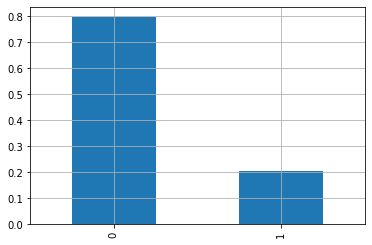

In [35]:
data['Exited'].value_counts(normalize=True).plot(kind='bar', grid=True);

Почти ровно 20 процентов из всего датасета (из 10 тыс человек, 2 тыс ушли), наблюдается явный дисбаланс классов. 

In [36]:
display(features_train.shape, features_test.shape)

(7500, 14)

(2500, 14)

### Модель случайный лес

In [37]:
%%time

parameters = {
    'n_estimators': range(50, 121, 5),
    'max_depth': range(2, 25),
    'min_samples_leaf': range(1, 7)
}

model_random_forest = RandomForestClassifier(random_state=12345)

metrics = ['f1', 'roc_auc']

search = RandomizedSearchCV(model_random_forest, parameters, n_iter=1, cv=5, scoring=metrics, refit='f1')
search.fit(features_train, target_train)
results = search.cv_results_

print('F1 on VALID:', '%.4f' %search.best_score_)
print('AUC-ROC on VALID:', '%.4f' %results['mean_test_roc_auc'].mean())
print(pd.Series(search.best_params_))

F1 on VALID: 0.5173
AUC-ROC on VALID: 0.8556
n_estimators        110
min_samples_leaf      4
max_depth             7
dtype: int64
CPU times: user 2.82 s, sys: 15.5 ms, total: 2.83 s
Wall time: 2.84 s


F1-мера на валидационных данных - 0.5603 (в моей итерации, с текущим std и гиперпараметрами), этого недостаточно для соблюдения условиия (>=0.59), показатель AUC-ROC - 0.8465

Случайно были подобраны параметры:

n_estimators        95

min_samples_leaf     2

max_depth           15

In [38]:
parameters = {
    'max_iter': range(100, 1000)
}

model_logistic_regression = LogisticRegression(random_state=12345, solver='liblinear')

metrics = ['f1', 'roc_auc']

search = RandomizedSearchCV(model_logistic_regression, parameters, n_iter=1, cv=3, scoring=metrics, refit='f1')
search.fit(features_train, target_train)
results = search.cv_results_

print('F1 on VALID:', '%.4f' %search.best_score_)
print('AUC-ROC on VALID:', '%.4f' %results['mean_test_roc_auc'].mean())
print(pd.Series(search.best_params_))

F1 on VALID: 0.4744
AUC-ROC on VALID: 0.8274
max_iter    846
dtype: int64


### Вывод

Разделил на две выборки для дальнейшего подбора гиперпараметров с помощью перекрестной проверки, это черновой вариант - наброски окончательной модели, далее, обучил модель без учета дисбаланса, результат неудовлетворительный. Необходимо дополнительно исследовать дисбаланс классов в целевом признаке и решить ее.

## Борьба с дисбалансом

### Взвешивание классов

#### Случайный лес

Сначала, обучил случайный лес без дисбаланса целевого признака (class_weight='balanced') чтобы посмотреть на результат

In [39]:
parameters = {
    'n_estimators': range(50, 251, 5),
    'max_depth': range(2, 30),
    'min_samples_leaf': range(1, 6)
}

model_random_forest = RandomForestRegressor(random_state=12345, class_weight='balanced')

metrics = ['f1', 'roc_auc']

search = RandomizedSearchCV(model_random_forest, parameters, n_iter=1, cv=3, scoring=metrics, refit='f1')
search.fit(features_train, target_train)
results = search.cv_results_

print('F1 on VALID:', '%.4f' %search.best_score_)
print('AUC-ROC on VALID:', '%.4f' %results['mean_test_roc_auc'].mean())
print(pd.Series(search.best_params_))

F1 on VALID: 0.6128
AUC-ROC on VALID: 0.8522
n_estimators        165
min_samples_leaf      3
max_depth            12
dtype: int64


F1 на валиде - 0.6175, AUC-ROC - 0.8508

Случайно были подобраны параметры:

n_estimators        130

min_samples_leaf      4

max_depth            12

#### Логистическая регрессия

Для логистической регресси численные признаки отмасшатабированы (не знаю, считать ли численными признаки с типом uint8 или нет для линейных моделей?), теперь необходимо решить проблему дисбаланса целевого признака для линейных моделей (сначала простой class_weight='balanced'):

In [40]:
%%time

parameters = {
    'max_iter': range(100, 1000)
}

model_logistic_regression = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

metrics = ['f1', 'roc_auc']

search = RandomizedSearchCV(model_logistic_regression, parameters, n_iter=1, cv=3, scoring=metrics, refit='f1')
search.fit(features_train, target_train)
results = search.cv_results_

print('F1 on VALID:', '%.4f' %search.best_score_)
print('AUC-ROC on VALID:', '%.4f' %results['mean_test_roc_auc'].mean())
print(pd.Series(search.best_params_))

F1 on VALID: 0.5600
AUC-ROC on VALID: 0.8282
max_iter    200
dtype: int64
CPU times: user 225 ms, sys: 361 ms, total: 586 ms
Wall time: 589 ms


F1 on VALID: 0.4854

AUC-ROC on VALID: 0.7680

max_iter    469

F1 on VALID: 0.8450

AUC-ROC on VALID: 0.7720

max_iter    202

Вероятно, имеет место какая-то ошибка (сомневаюсь, что можно получить значение f1-меры выше 0.61 с моими текущими знаниями).

Значение F1 слишком высокое, я бы мог поверить, если бы это была не логистическая регрессия (все равно, провею на тесте данную модель...

### Изменение порога вероятности

Суть в следующем: получаем вероятности классов с помощью функции predict_proba(), затем присваиваем самостоятельно класс в зависимости от установленной вероятности. 

Задача поглядеть как порог влияет на полноту и точность (чтобы подобрать наилучший баланс для гармонической средней меж ними - f1). Для этого сначала получил валидационную выборку (чтобы от нее считать пороги вероятностей и установить ее, чтобы потом проверить на тестовой), а для этого необходимо по-новой разделить на выборки, только теперь уже на три (обучение, валид, тест) с соотношением 3:1:1, так как далее кросс-валидации нет (параметры уже подобраны), но есть работа с моделью и предсказаниями

In [41]:
# Прошу прощения за не совсем чистый код, надеюсь, я не вызвал слишком большую путаницу, 
# проверять код другого программиста - тяжелое занятие, а программиста-новичка тем более.
# Так как пишу один, а не в команде, то предоставлен сам себе, сам выбираю названия переменных, план написания, исследования...
train, test_valid = train_test_split(
    data, test_size=.40, random_state=12345)

test, valid = train_test_split(
    test_valid, test_size=.50, random_state=12345)

target_train = train['Exited']
features_train = train.drop('Exited', axis=1)

target_valid = valid['Exited']
features_valid = valid.drop('Exited', axis=1)

target_test = test['Exited']
features_test = test.drop('Exited', axis=1)

In [42]:
numeric = list(data.select_dtypes(['int', 'float']).columns) # 'uint8'
numeric.remove('Exited')
numeric.remove('IsActiveMember')

scaler = StandardScaler()

features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [43]:
features_train

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProductsOne,NumOfProductsTwo,NumOfProductsThree,NumOfProductsFour
7479,-0.886751,-0.373192,1.029948,1.232271,0.642466,0,-0.187705,0,1,1,1,0,0,0
3411,0.608663,-0.183385,1.029948,0.600563,-1.556504,0,-0.333945,0,0,0,1,0,0,0
6027,2.052152,0.480939,-0.703193,1.027098,-1.556504,1,1.503095,1,0,1,0,1,0,0
1247,-1.457915,-1.417129,0.336692,-1.233163,0.642466,0,-1.071061,0,0,1,0,1,0,0
3716,0.130961,-1.132419,-1.049822,1.140475,-1.556504,0,1.524268,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4478,-1.073677,-0.752805,-0.356565,-1.233163,-1.556504,1,-1.278361,0,0,1,0,1,0,0
4094,-1.447531,-0.942612,1.723205,-1.233163,-1.556504,1,-1.281307,0,0,1,0,1,0,0
3492,0.027113,0.575842,-1.396450,-0.310229,-1.556504,1,-0.903158,0,0,0,1,0,0,0
2177,0.151731,-1.417129,-0.356565,-1.233163,-1.556504,1,-1.128539,0,0,0,0,1,0,0


In [44]:
display(features_train.shape, features_valid.shape, features_test.shape)

(6000, 14)

(2000, 14)

(2000, 14)

#### Логистическая регрессия

In [45]:
# параметры модели брал от результата кросс-валидаций
model_forest = LogisticRegression(random_state=12345, solver='liblinear', max_iter=202)
model_forest.fit(features_train, target_train)
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_f1_score = 0
best_threshold = 0
best_precision = 0
for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1_metric = (2 * precision * recall) / (precision + recall)
    
    if f1_metric > best_f1_score:
        best_f1_score = f1_metric
        best_threshold = threshold
        best_precision = precision
        best_recall = recall

print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-метрика = {:.3f}".format(
    best_threshold, best_precision, best_recall, best_f1_score))

Порог = 0.00 | Точность = 0.198, Полнота = 0.638, F1-метрика = 0.302


Метрика слабо отличается от случайной, перешел к другой модели - случайный лес

#### Случайный лес

In [46]:
# параметры модели брал от результата кросс-валидации
model_forest = RandomForestClassifier(random_state=12345, n_estimators=165, min_samples_leaf=4, max_depth=10)
model_forest.fit(features_train, target_train)
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_f1_score = 0
best_threshold = 0
best_precision = 0
for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1_metric = (2 * precision * recall) / (precision + recall)
    
    if f1_metric > best_f1_score:
        best_f1_score = f1_metric
        best_threshold = threshold
        best_precision = precision
        best_recall = recall

print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-метрика = {:.3f}".format(
    best_threshold, best_precision, best_recall, best_f1_score))

Порог = 0.48 | Точность = 0.427, Полнота = 0.560, F1-метрика = 0.485


Есть возможность увеличить метрику F1 до 0.62 при вероятности положительного класса - 0.34. Чтобы избежать написания функции, которая самостоятельно присваивает нули и единички классу, сначала попробовал изменить вес класса, с помощью параметра class_weight:

In [47]:
best_f1_score = 0.0
best_model = None
for class_weight in list(np.arange(0.4, 2.2, 0.2)): # Без преобразования в список не работает, так как numpy меняет тип в свой
    class_weight = float(class_weight)
    model_forest = RandomForestClassifier(random_state=12345,
                                          n_estimators=165,
                                          min_samples_leaf=4,
                                          max_depth=10,
                                          class_weight={0:class_weight}) # Тот самый параметр с весом

    model_forest.fit(features_train, target_train)
    predict_valid = model_forest.predict(features_valid)
    f1 = f1_score(target_valid, predict_valid)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model_forest

In [48]:
best_model

RandomForestClassifier(class_weight={0: 1.6000000000000005}, max_depth=10,
                       min_samples_leaf=4, n_estimators=165,
                       random_state=12345)

In [49]:
best_f1_score

0.48466257668711654

Удалось достичь f1 - 0.62, значит, писать функцию не нужно. Пробовал сначала менять вес положительного класса, но не получил значимых результатов

*Знаю, что и здесь можно использовать кросс-валидацию только не случайный подбор, а другую функцию - GridSearch() вроде, но с ней никогда не работал*

### Вывод

Подобрал гиперпараметры методом кросс-валидации, также применил простейшие приемы борьбы с дисбалансом классов, например, использовал параметр class_weight='balanced', который сбалансировал классы между собой, результат улучшился, примерно с 0.57 до 0.60, этот успех заставил и далее исследовать вопрос дисбаланса для улучшения метрик, обучил две модели - случайный лес и логистическую регрессию, последняя, впрочем, окончательно показала свою малую эффективность по сраввнению со случайным лесом, принято решение работать далее только со случайным лесом. Применен метод увеличения выборки для борьбы с дисбалансом классов, но только это не принесло большой пользы, разве что, натолкнуло на изменение порога вероятности, так как при увеличении выборки f1 метрика показала феноменальную эффективность, но среднюю на тестовых данных, предполагаю, что это связано с тем, что количество положительных классов значительно увеличилось, увеличив вероятность "угадывания" моделью класса, но скорее всего, эта эффективность на тестовых данных значительно ниже чем на увеличенной и перемешанной выборке, значит, эта эффективность - иллюзия. Решено было изменить порог вероятности класса, это дало определенные результаты увеличив метрику f1 до 0.62 на случайном лесе, но чтобы не писать отдельно функцию, которая меняет порог вероятности, было принято решение изменить вес класса в эту сторону, что и было сделано. Удалось досчить f1 - 0.62 на валиде

## Тестирование модели

### Случайный лес

Сначала, объеденил выборки (обучение + валид) для обучения и финальной проверки на тестовых данных

In [50]:
features_full_train = pd.concat([features_train, features_valid])
target_full_train = pd.concat([target_train, target_valid])

In [51]:
model_forest = RandomForestClassifier(random_state=12345,
                                          n_estimators=165,
                                          min_samples_leaf=4,
                                          max_depth=10,
                                          class_weight={0:0.4})
model_forest.fit(features_full_train, target_full_train)
predict_test = model_forest.predict(features_test)

In [52]:
f1_score(target_test, predict_test)

0.6264150943396226

In [53]:
roc_auc_score(target_test, predict_test)

0.7573917698510153

Итак, максимальный показатель метрики f1 на тестовых данных ~ 0.65. Это лучший показатель на наиболее эффективной модели - случайном лесе. ROC-AUC (отличие от случайной модели, площадь на графике, как я понимаю) ~ 0.77

## Вывод

Датасет был с пропусками и категориальными признаками, заменил пропуски случайным числом от 1 до 10 с определенной вероятностью (например, вероятность числа 10 меньше вероятности числа 2), проведено исследование задачи, баланса классов, перепробованы различные варианты обучения со случайным подбором, а также пришел к тому, что значимое влияние оказывает вес отрицательного класса, а не положительного. Применены две модели, одна из библиотеки линейных моделей - логистическая регрессия, а дргуая из ансамбля - случайный лес, случайный лес показал на всех предварительных этапах лучшие результаты по метрике f1, с ним в дальнейшем и работал, удалось достичь метрики f1 ~ 0.65 (с округлением до ближайшего), на тестовых данных, но есть определенная погрешность при каждом проходе по ячейкам, так как в функции заполнения пропусков нет фиксирования псевдослучайности, также перед обучением и тестированием была проведена контактация, обьединение выборок (обучение и валид) для большего количества данных при подгонке модели. Был применен метод увеличения выборки, он показал феноменальные результаты на валиде, но на тесте показал средний результат на модели случайного леса ~ 0.60 и ~ 0.50 на логистической регрессии.

Гиперпараметры модели случайного леса:

- `n_estimators` - 165
- `min_samples_leaf` - 4
- `max_depth` - 10
- `class_weight` - {0:0.4} (вес 0.4 для класса 0)

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*